In [79]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: C:\Users\Himesh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [80]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
from math import ceil
from random import shuffle
from itertools import chain
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.models import Model
import tensorflow.keras.optimizers as opt
import pandas as pd
from transformers import RobertaTokenizer
import os
import transformers
from pathlib import Path
import torch
import numpy as np
from sklearn.utils import shuffle

In [81]:
#X, y = make_classification(n_samples=1000, n_features=100, n_informative=10, n_redundant=90, random_state=1)
# print(type(X))

In [82]:
#basePath = r'/home/himesh/TagCoder/pythonNotebook'
basePath = r'C:\Users\Himesh\Documents\thesis\pythonNotebook'
positivePathSuffix = '/Positive'
negativePathSuffix = '/Negative'
tokenizerInPath = basePath + '/tokenizerIn'
tokenizerOutPath = basePath + '/tokenizerOut'
train_ratio = 0.7

In [83]:
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-cased")
#tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-base')

In [84]:
def compute_max(arr, dim="width", z=2):
    mn = np.mean(arr, axis=0)
    sd = np.std(arr, axis=0)
    final_list = [x for x in arr if (x <= mn + z * sd)]  # upper outliers removed
    rmn2 = len(arr) - len(final_list)
    print('{} array size '.format(dim) + str(len(arr)))
    print('min {} '.format(dim) + str(min(arr)))
    print('max {} '.format(dim) + str(max(arr)))
    print('mean {} '.format(dim) + str(np.nanmean(arr)))
    print('standard deviation ' + str(np.std(arr)))
    print('median {} '.format(dim) + str(np.nanmedian(arr)))
    print('number of upper outliers removed ' + str(rmn2))
    print('max {} excluding upper outliers '.format(dim) + str(max(final_list)))
    return max(final_list)

In [85]:
def _get_outlier_threshold(path, z, is_c2v):
    print('Getting outlier threshold via inner method. The path passed is '+path)
    lengths = []
    for root, dirs, files in os.walk(path):
        for f in files:
            if f.startswith("."):
                continue
            filepath = os.path.join(root, f)
            with open(filepath, "r", errors='ignore') as file:
                #print('Working with file'+ filepath)
                for line in file:
                    input_str = line.replace("\t", " ")
                    if is_c2v:
                        np_arr = np.fromstring(input_str, dtype=np.float, sep=" ")
                    else:
                        np_arr = np.fromstring(input_str, dtype=np.int32, sep=" ")
                    cur_width = len(np_arr)
                    #print('cur_width: '+str(cur_width))
                    lengths.append(cur_width)
    
    #print(' '.join(map(str, lengths)))
    #print(compute_max(lengths,z=z))
    return compute_max(lengths, z=z)


In [86]:
len1 = _get_outlier_threshold((os.path.join(tokenizerOutPath,'ComplexMethod','Positive')),z=1,is_c2v = False)
len2 = _get_outlier_threshold((os.path.join(tokenizerOutPath,'ComplexMethod','Negative')),z=1,is_c2v = False)

if len1 > len2:
    maxLength = len1 
else:
    maxLength = len2

print(maxLength)

Getting outlier threshold via inner method. The path passed is C:\Users\Himesh\Documents\thesis\pythonNotebook/tokenizerOut\ComplexMethod\Positive
width array size 944
min width 512
max width 2190
mean width 602.8792372881356
standard deviation 201.7674766994313
median width 512.0
number of upper outliers removed 98
max width excluding upper outliers 804
Getting outlier threshold via inner method. The path passed is C:\Users\Himesh\Documents\thesis\pythonNotebook/tokenizerOut\ComplexMethod\Negative
width array size 1708
min width 512
max width 8045
mean width 618.1996487119438
standard deviation 365.292697212631
median width 512.0
number of upper outliers removed 107
max width excluding upper outliers 974
974


In [87]:
smellList = ['ComplexMethod']
final_text = ""

print(tokenizerInPath)
for smell in smellList:
    smellPath = os.path.join(tokenizerInPath, smell,'Positive',"")
    #print(smellPath)
    
    for file in os.listdir(smellPath):
        #print(os.path.basename(file))
        with open(os.path.join(smellPath, file),"r",encoding='utf-8') as read_file:
            try:
                text = read_file.read()
                tokenized_text = tokenizer.tokenize(text,padding = "max_length")
                input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
                #print(len(input_ids))
                # if len(input_ids) > maxLength:
                #     maxLength = len(input_ids)
                # modint = (len(input_ids)) % 512
                # #print(modint)
                # length = len(input_ids) - modint
            
                # input_ids = input_ids[0:length]
                final_text += ' '.join(map(str, input_ids))+'\n'
            except Exception as e:
                print(e)
                pass
    #Path(os.path.join(tokenizerOutPath,smell,positivePathSuffix, 'tokenizer.tok')).touch(exist_ok=True)        
    with open(os.path.abspath(os.path.join(tokenizerOutPath,smell,'Positive', 'tokenizer.tok')),'w',errors='ignore') as out_file:
        #out_file.touch(exist_ok=True)
        #print(final_text)
        out_file.write(final_text)
    
smellPath = os.path.join(tokenizerInPath, smell,'Negative',"")
print(smellPath)

for file in os.listdir(smellPath):
    #print(os.path.basename(file))
    with open(os.path.join(smellPath, file),"r",encoding='utf-8') as read_file:
        try:
            text = read_file.read()
            tokenized_text = tokenizer.tokenize(text,padding = "max_length")
            input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
            #print(len(input_ids))
            # if len(input_ids) > maxLength:
            #     maxLength = len(input_ids)
            
            # modint = (len(input_ids)) % 512
            # #print(modint)
            # length = len(input_ids) - modint
           
            # input_ids = input_ids[0:length]
           
            final_text += ' '.join(map(str, input_ids))+'\n'
        except Exception as e:
            print(e)
            
            pass
#Path(os.path.join(tokenizerOutPath,smell,positivePathSuffix, 'tokenizer.tok')).touch(exist_ok=True)        
with open(os.path.abspath(os.path.join(tokenizerOutPath,smell,'Negative', 'tokenizer.tok')),'w',errors='ignore') as out_file:
    #out_file.touch(exist_ok=True)
    #print(final_text)
    out_file.write(final_text)


C:\Users\Himesh\Documents\thesis\pythonNotebook/tokenizerIn
C:\Users\Himesh\Documents\thesis\pythonNotebook/tokenizerIn\ComplexMethod\Negative\


In [97]:
X = []
Y = []

#num_lines_pos = sum(1 for line in open(os.path.join(tokenizerOutPath,smell,'Positive', 'tokenizer.tok'),"r"))
with open(os.path.join(tokenizerOutPath,smell,'Positive', 'tokenizer.tok'),"r") as read_file:
    #text = read_file.read()
  
    #text = text.replace('\n', ' ')
    #text = text.replace('\r', ' ')
    #print(text)
    #posInput = np.fromstring(text, sep=" ").tolist()
    #print(len(posInput))
    for line in read_file:
        if line == '\n':
            continue 
        arr = np.fromstring(line, dtype=np.float64, sep=" ",count=maxLength)
        arr_size = len(arr)
        if arr_size <= maxLength:
                    arr[arr_size:maxLength] = 0
        X.append(arr)
        Y = Y +[1]

with open(os.path.join(tokenizerOutPath,smell,'Negative', 'tokenizer.tok'),"r") as read_file:
    # text = read_file.read()
  
    # text = text.replace('\n', ' ')
    # text = text.replace('\r', ' ')
    # #print(text)
    # negInput = np.fromstring(text, dtype=np.int32, sep=" ").tolist()

    for line in read_file:
        if line == '\n':
            continue
        arr = np.fromstring(line, dtype=np.float64, sep=" ",count=maxLength)
        arr_size = len(arr)
        if arr_size <= maxLength:
                    arr[arr_size:maxLength] = 0
        print(np.max(arr))
        X.append(arr)
        Y = Y +[0]
print((maxLength))
print(np.max(X))
X = np.asarray(X)
print(np.where(X == 2099281184))
print(np.max(X))
n_inputs = X.shape[1]
X,Y = shuffle(X,Y)
print(np.max(X))


25131.0
26939.0
25837.0
28108.0
27825.0
27451.0
26927.0
27412.0
26280.0
27934.0
26280.0
26280.0
28108.0
26280.0
26280.0
26280.0
28108.0
28108.0
28108.0
28108.0
28108.0
28108.0
27250.0
26280.0
26280.0
26294.0
26280.0
26280.0
26280.0
27412.0
28108.0
28108.0
28108.0
26280.0
27922.0
27370.0
27250.0
27922.0
26280.0
28108.0
27412.0
27412.0
27533.0
28108.0
27510.0
24162.0
25290.0
25290.0
27451.0
26280.0
27905.0
26280.0
26889.0
27528.0
28117.0
26280.0
27328.0
27914.0
28108.0
27530.0
28108.0
26280.0
27412.0
27524.0
27467.0
26280.0
27500.0
28076.0
26280.0
28108.0
28108.0
27250.0
27565.0
24704.0
28108.0
28108.0
26554.0
23994.0
25021.0
27530.0
27451.0
26967.0
26280.0
26280.0
26909.0
27412.0
25667.0
28108.0
24380.0
24162.0
27250.0
27451.0
21778.0
27412.0
28117.0
27487.0
28108.0
26280.0
26280.0
28108.0
27801.0
28115.0
26868.0
28117.0
26280.0
24890.0
27250.0
28108.0
27989.0
27103.0
27103.0
22825.0
26574.0
27905.0
28108.0
26280.0
27250.0
28028.0
27250.0
27532.0
27451.0
27412.0
28108.0
28108.0
24162.0


In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 1 - train_ratio, random_state=1)
max_features = int(max(np.max(X_train), np.max(X_test)))
print(np.where(X_train == 2099264364))
print(np.max(X_train))
#pd.options.display.max_seq_items = 4000
#print(np.max(np.max(X_train,axis=1)))
X_train = X_train.reshape((len(y_train), maxLength)) 
X_test = X_test.reshape((len(y_test), maxLength))

(array([], dtype=int64), array([], dtype=int64))
28117.0


In [99]:
import tensorflow


model = tensorflow.keras.models.Sequential()
#input_layer = Input(shape=(maxLength,1))
model.add(tensorflow.keras.layers.Embedding(input_dim=max_features + 1,
                                       output_dim=32,
                                       mask_zero=True))
for i in range(0, 1):
    model.add(tensorflow.keras.layers.LSTM(64, return_sequences=True, recurrent_dropout=0.1, dropout=0.1))
    # model.add(tf.keras.layers.Dropout(config.dropout))
model.add(tensorflow.keras.layers.LSTM(64, recurrent_dropout=0.1, dropout=0.1))
model.add(tensorflow.keras.layers.Dropout(0.2))
model.add(tensorflow.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

earlystop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 min_delta=0.0001,
                                                 patience=2,
                                                 verbose=1,
                                                 mode='auto')
model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])


In [100]:
model.fit(X_train.tolist(),
                  y_train,
                  epochs=20,
                  batch_size=32)

Epoch 1/20
58/58 [==============================] - 148s 2s/step - loss: 0.6557 - accuracy: 0.6455
Epoch 2/20
58/58 [==============================] - 143s 2s/step - loss: 0.6485 - accuracy: 0.6519
Epoch 3/20
58/58 [==============================] - 142s 2s/step - loss: 0.6468 - accuracy: 0.6519
Epoch 4/20
58/58 [==============================] - 141s 2s/step - loss: 0.6440 - accuracy: 0.6509
Epoch 5/20
58/58 [==============================] - 145s 2s/step - loss: 0.6392 - accuracy: 0.6519
Epoch 6/20
58/58 [==============================] - 142s 2s/step - loss: 0.6272 - accuracy: 0.6492
Epoch 7/20
58/58 [==============================] - 143s 2s/step - loss: 0.6209 - accuracy: 0.6498
Epoch 8/20
58/58 [==============================] - 143s 2s/step - loss: 0.6138 - accuracy: 0.6627
Epoch 9/20
58/58 [==============================] - 144s 2s/step - loss: 0.6017 - accuracy: 0.6713
Epoch 10/20
58/58 [==============================] - 144s 2s/step - loss: 0.5887 - accuracy: 0.6697
Epoch 11/

In [ ]:
import collections
from tensorflow.keras.models import load_model

In [ ]:
model = load_model('encoder_lstm_emb.h5')

In [ ]:
from keras.models import Sequential 
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [ ]:
X_test.shape

In [ ]:
vocab_size = 513
embedding_dim = 8
y_train = np.array(y_train)
y_test = np.array(y_test)

In [101]:
yhat = model.predict(X_test)

25/25 [==============================] - 9s 328ms/step


In [ ]:
def round(x, decimals=0):
    b = 10**decimals
    return torch.round(x*b)/b

[[0.69771636]
 [0.7257721 ]
 [0.37708357]
 [0.25137112]
 [0.86332536]
 [0.03649749]
 [0.45098466]
 [0.35334724]
 [0.16339181]
 [0.03397869]
 [0.2639094 ]
 [0.39797625]
 [0.6617013 ]
 [0.53965515]
 [0.04620043]
 [0.82217646]
 [0.60251474]
 [0.71526515]
 [0.3419479 ]
 [0.03464046]
 [0.05750695]
 [0.03547179]
 [0.37450433]
 [0.13902819]
 [0.38859463]
 [0.03557695]
 [0.26546204]
 [0.26605153]
 [0.51583517]
 [0.19001943]
 [0.5153911 ]
 [0.39739317]
 [0.8130878 ]
 [0.7378879 ]
 [0.11506125]
 [0.09016054]
 [0.06917579]
 [0.0106322 ]
 [0.83673257]
 [0.45435855]
 [0.5309084 ]
 [0.64230937]
 [0.746664  ]
 [0.7947939 ]
 [0.34889963]
 [0.16666828]
 [0.3153465 ]
 [0.2005526 ]
 [0.5886848 ]
 [0.3832025 ]
 [0.34703073]
 [0.6560433 ]
 [0.469403  ]
 [0.4991224 ]
 [0.32538885]
 [0.44801414]
 [0.13108689]
 [0.4615569 ]
 [0.43025365]
 [0.4615569 ]
 [0.11426657]
 [0.12293005]
 [0.1420144 ]
 [0.21953684]
 [0.34103426]
 [0.68483555]
 [0.16339181]
 [0.69833994]
 [0.16795063]
 [0.47213668]
 [0.7193804 ]
 [0.76

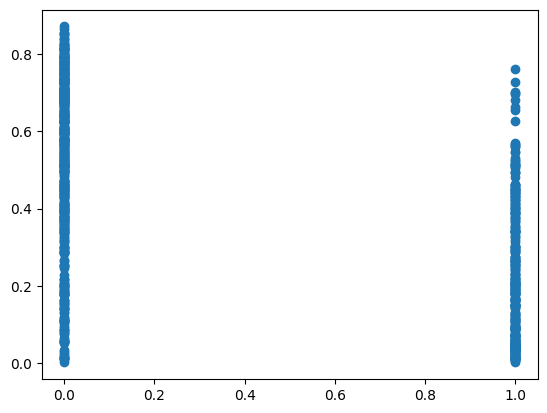

              precision    recall  f1-score   support

           0       0.42      0.40      0.41       498
           1       0.08      0.09      0.08       298

    accuracy                           0.29       796
   macro avg       0.25      0.25      0.25       796
weighted avg       0.30      0.29      0.29       796

0.08373590982286634


In [103]:

#scores = model2.evaluate(X_test, y_test, verbose=1)
print(yhat)
#print(y_test[1])
y_pred_bool = pd.cut(x=yhat.flatten(),bins=[0,0.5,1],labels=[0,1])
#y_pred_bool =  torch.round(torch.tensor(yhat))
#y_pred_bool = y_pred_bool.numpy()
print(collections.Counter(y_pred_bool.tolist()))
plt.scatter(y_test,yhat)
plt.show()
#print(pd.DataFrame(y_pred_bool).describe())
#print("Accuracy: %.2f%%" % (scores[1]*100)) 
print(classification_report(y_test, y_pred_bool))
acc = accuracy_score( y_pred_bool,y_test)
# print(acc)
print(f1_score(y_test, y_pred_bool))